In [27]:
# set root
import os
#root = '/home/bramiozo/DATA/ISIC2020'
root = '/media/bramiozo/DATA-FAST/kaggle/image_classification/MEDICAL/melanoma'
os.chdir(root)  

settings = dict()
settings['resolution'] = (64, 64) # $ 128, 256, 384
settings['centercrop'] = None
settings['randomcrop'] = None # (96, 64) # resize->random crop
settings['res_model_dependent'] = False # if true checks pre-trained model for preferred resolution
settings['begin_resize'] = False
settings['base_model'] = 'tf_efficientnet_b0_ns' # 'tf_efficientnet_b0_ns' # 'regnety_002', 'tf_efficientnet_b2_ns'
settings['load_model'] =  None # '../_models/melanoma/good/tf_efficientnet_b0_ns_DepthALL_20epochs_lastALLlayers_randomcropped_balancingWsampler_batchsize32_optimizerAdaTuneAdam_numClass2_weightedLoss_wAugmentation_res300x300_datTRAINING_1024_BINOMIAL_numGPU1_cross_entropy.pyth'
settings['image_transforms'] = True
settings['random_resize_crop'] = False
settings['visualize_transforms'] = True
settings['optimiser'] = 'AdaTuneAdam' # 'AdaTuneAdam'
settings['num_epochs'] = 20
settings['max_batches'] = None # if None , run all batches, only set to integer for debugging!
settings['num_loader_workers'] = 12 # if 0 then loaded into memory
settings['batch_size'] = 64
settings['batch_size_validation'] = 64
settings['use_cpu'] = False
settings['num_gpu'] = 1
settings['balancing'] = 'sampler' # 'optimizer' / 'sampler' 
settings['criterion'] = 'cross_entropy' # nn.BCEWithLogitsLoss(), 'focal', 'cross_entropy'
settings['weighted_loss'] = True
settings['train_schedule'] = 'CyclicLR' # 'StepLR' # CyclicLR StepLR CosAnnealing
settings['learning_rate'] = 1e-3
settings['lrStep'] = 8
settings['use_amp'] = True
settings['cross_folds'] = 5

settings['num_layers_trainable'] = -1 # last layers in the network,. -1 means all layers
settings['data_folder'] = 'TRAINING_1024/TRAIN/' 

In [2]:
''' 
    A.Transpose(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
'''

' \n    A.Transpose(p=0.5),\n    A.OneOf([\n        A.MotionBlur(blur_limit=5),\n        A.MedianBlur(blur_limit=5),\n        A.GaussianBlur(blur_limit=5),\n        A.GaussNoise(var_limit=(5.0, 30.0)),\n    ], p=0.7),\n\n    A.OneOf([\n        A.OpticalDistortion(distort_limit=1.0),\n        A.GridDistortion(num_steps=5, distort_limit=1.),\n        A.ElasticTransform(alpha=3),\n    ], p=0.7),\n    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),\n'

# A getting-started script

Most simple approach:
**Base model** 
1. load in images from disc, ISIC2019 AND ISIC2020
2. do basic augmentation using affine transformation
3. train an existing all-v-all model with ImageNet pre-trained weights

Denote as ```basic-{neural architecture}-{# epochs}``` 

Suggested base-models:
* Xception, InceptionV4
* ResNext50, ResNext101, ResNext152
* WideResNet28, wide_resnet50_2, wide_resnet101_2
* RegNetY200MF, 400MF, 600MF, 800MF, 1.6GF...32GF
* EfficientNet-B0, B1, B2, B3, B4, B5, B6, B7, B8
* EfficientNet-L2


Development options:
* arch: Use transformers
* arch: segmentation model
* feat: advanced image augmentation
* feat: advanced feature augmentation
* feat/arch: meta features 
* devops: fast ingestion of training images
* implement good ideas from : [here](https://www.kaggle.com/haqishen/1st-place-soluiton-code-small-ver) and [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175412) 
    * use multi-predictions instead of binomial
    * use HSV and optic distortions
    * use AMP APEX!
    * add warmup

**TO DO**
* create model_creation function, including the scheduler and the optimizer
* create dataframe loader
* allow for multimodal input
* add label smoothing
* add attention block, swish block and standard block to combine meta and image embeddings: make selectable
* make more generic, for other image rec. problems!
* write tfrecords WITH meta data: https://www.kaggle.com/aziz69/how-to-pseudo-labelling-create-tf-records
* add multi-sample dropout

In [3]:
%load_ext autoreload
%autoreload 2

# internals
import logging
import time
import os
import gc
import copy
import sys
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple
from tqdm import tqdm

# neural network stuffs
import torch
import torch.nn as nn
from torchvision import models 

# data loading
from torchvision import datasets
from torch.utils.data import DataLoader
import timm
import pretrainedmodels
from efficientnet_pytorch import EfficientNet
from torchvision import models 


# image manipulation
import pydicom
import skimage
import cv2
import albumentations
import PIL
#from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
#                            RandomBrightness, RandomContrast, HueSaturationValue, Blur, GaussNoise,
#                            Rotate, RandomResizedCrop, Cutout, MedianBlur, MotionBlur, GridDistortion)
from PIL import Image, ImageEnhance, ImageOps


from torchvision import transforms
#from opencv_transforms import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import *

from matplotlib import pyplot as plt
from IPython import display


from sklearn.metrics import roc_auc_score, average_precision_score, auc, roc_curve, recall_score
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline
%matplotlib notebook

'''
torchvision.models
shufflenet_v2_x2_0
squeezenet1_1
mnasnet1_3

timm
mobilenetv2_120d
mobilenetv3_large_100
mixnet_m
'''

'\ntorchvision.models\nshufflenet_v2_x2_0\nsqueezenet1_1\nmnasnet1_3\n\ntimm\nmobilenetv2_120d\nmobilenetv3_large_100\nmixnet_m\n'

In [4]:
#import inspect

In [5]:
class Tinterpolate:
    def __init__(self, size, random_resize_crop=False):
        self.size = size
        self.rnd_resize_crop = random_resize_crop
    def __call__(self, x):
        if self.rnd_resize_crop:
            return TF.to_tensor(TF.RandomResizedCrop(TF.to_pil_images(x), size=self.size))
        else:
            return TF.to_tensor(TF.resize(TF.to_pil_image(x), size=self.size))
        

# credits: https://www.kaggle.com/c/siim-isic-melanoma-cp=0.5, num_holes=8, max_h_size=8, max_w_size=8lassification/discussion/159476
# credits: https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up
def random_microscope(img):
    circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        np.random.randint(img.shape[0]//1.75 - 1, img.shape[0]//1.75 + 15), # radius
                        (0, 0, 0), # color
                        -1)

    mask = circle - 255
    img = np.multiply(img, mask)
    return img

class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p
    
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        img = np.asarray(img)
        if np.random.random() <self.p:
            img = random_microscope(img)
        img = Image.fromarray(np.uint8(img))
        return img
    
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

class AutoContrast:
    def __init__(self, p: float= 0.5, cutoff: float = 0.2):
        self.p = p        
        self.cutoff = cutoff
    
    def __call__(self, img):
        if np.random.random() < self.p:
            res = ImageOps.autocontrast(img, cutoff=self.cutoff)
            return res
        else:
            return img
    
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
class Equalize:
    def __init__(self, p: float= 0.5):
        self.p = p

    
    def __call__(self, img):
        if np.random.random() < self.p:
            return ImageOps.equalize(img)
        else:
            return img
    
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    

class Sharpness:
    def __init__(self, p: float= 0.5, magnitude: int=3):
        self.p = p
        self.magnitude = magnitude
        self.magnitudes = np.linspace(0.1, 1.9, 11)
    
    def __call__(self, img):
        if np.random.random() < self.p:
            return ImageEnhance.Sharpness(img)\
                                .enhance(np.random.uniform(self.magnitudes[self.magnitude], 
                                                        self.magnitudes[self.magnitude+1]))
        else:
            return img
    
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

# albumentations.augmentations.transforms.Cutout(num_holes=5, 
#max_h_size=32, max_w_size=32, fill_value=0, always_apply=False, p=0.2)
#from albumentations.augmentations.transforms import Cutout as AlbCutout

class CutOut():
    def __init__(self, p: float=0.5, min_holes: int=2, max_holes: int=6, 
                 fill_value: int=0, max_height: int=32, max_width: int=32,
                 min_height: int=8, min_width: int=8):
        self.p = p
        self.min_holes = min_holes
        self.max_holes = max_holes
        self.fill_value = fill_value
        self.max_height = max_height
        self.max_width = max_width
        self.min_height = min_height
        self.min_width = min_width
        
    def __call__(self, img):
        if np.random.random()<self.p:
            
            img = np.array(img)
            height, width = img.shape[:2]

            holes = []
            for _n in range(np.random.randint(self.min_holes, self.max_holes)):
                hole_height = np.random.randint(self.min_height, self.max_height)
                hole_width = np.random.randint(self.min_width, self.max_width)

                y1 = np.random.randint(0, height - hole_height)
                x1 = np.random.randint(0, width - hole_width)
                y2 = y1 + hole_height
                x2 = x1 + hole_width
                holes.append((x1, y1, x2, y2))
            
            res = albumentations.augmentations.transforms.F.cutout(img, holes, self.fill_value)
            return res # return Image.fromarray(res)
        else:
            return img
        
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
    
class GaussianBlur:
    def __init__(self, p=0.5, ksize=3, sigma=1):
        self.p = p
        self.ksize = ksize
        self.sigma = sigma
    
    def __call__(self, img):
        if np.random.random()<self.p:  
            img = np.array(img)
            res = albumentations.augmentations.transforms.F.gaussian_blur(img, self.ksize)
            return Image.fromarray(np.uint8(res)) 
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'
    


class Hair:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 1, p: float = 0.1, scale: float = 0.1, hairs_folder: str = ""):
        self.p = p
        self.scale=0.10
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        
        if np.random.random()< self.p:
            
            '''
            scale_percent = self.scale*100 # percent of original size
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)
            dim = (width, height)
            # resize image
            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)            
            '''
            n_hairs = np.random.randint(1, self.hairs)

            if not n_hairs:
                return img                
            
            
            #img = TF.resize(img, size=250)
            img = np.array(img)
            
            height, width, _ = img.shape  # target image width and height
            hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]

            for _ in range(n_hairs):
                hair = cv2.imread(os.path.join(self.hairs_folder, np.random.choice(hair_images)))
                hair = cv2.flip(hair, np.random.choice([-1, 0, 1]))
                hair = cv2.rotate(hair, np.random.choice([0, 1, 2]))
                hair = cv2.resize(hair, (width-50, height-50))
                

                h_height, h_width, _ = hair.shape  # hair image width and height
                print(img.shape, hair.shape)
                roi_ho = np.random.randint(0, img.shape[0] - hair.shape[0])
                roi_wo = np.random.randint(0, img.shape[1] - hair.shape[1])
                roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

                # Creating a mask and inverse mask
                img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
                ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
                mask_inv = cv2.bitwise_not(mask)
                # Now black-out the area of hair in ROI
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                # Take only region of hair from hair image.
                hair_fg = cv2.bitwise_and(hair, hair, mask=mask)
                # Put hair in ROI and modify the target image
                dst = cv2.add(img_bg, hair_fg)

                #img.setflags(write=1)
                img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
            return img
        else:
            return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'


# CLAHE
class CLAHE:
    def __init__(self, p=0.2):
        self.p = p

    def __call__(self, img):
        if np.random.random()<self.p:
            img = np.array(img)
            skimg = skimage.exposure.equalize_adapthist(img)*255
            return Image.fromarray(np.uint8(skimg))
        else:
            return img
        
    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
# Median blur
class MedianBlur:
    def __init__(self, p=0.5, ksize=3):
        self.p = p
        self.ksize = ksize
    
    def __call__(self, img):
        logging.info("MedianBlur")
        if np.random.random()<self.p:  
            img = np.array(img) # blur_limit
            res = albumentations.augmentations.transforms.F.median_blur(img, self.ksize)
            return Image.fromarray(np.uint8(res)) 
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'

# Motion blur
class MotionBlur:
    def __init__(self, p=0.5, ksize=5):
        self.p = p
        self.ksize = ksize
    
    def __call__(self, img):
        logging.info("MotionBlur")
        if np.random.random()<self.p:  
            img = np.array(img) # blur_limit
            res = albumentations.augmentations.transforms.F.motion_blur(img, self.ksize)
            return Image.fromarray(np.uint8(res))  
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'


# Gaussian noise
class OpticNoise:
    def __init__(self, p=0.5, sigma=1, noise_type='gauss'):
        '''
        noise_type:
            'gauss'     Gaussian-distributed additive noise.
            'poisson'   Poisson-distributed noise generated from the data.
            's&p'       Replaces random pixels with 0 or 1.
            'speckle'   Multiplicative noise using out = image + n*image,where
                        n is uniform noise with specified mean & variance.
        '''        
        self.p = p
        self.sigma = sigma
        self.noise_type = noise_type
        
    
    def _noisy(self, image):   
        # https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
        if self.noise_type == "gauss":
            row,col,ch= image.shape
            mean = 0
            gauss = np.random.normal(mean,self.sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = image + gauss
        elif self.noise_type == "s&p":
            row, col, ch = image.shape
            s_vs_p = 0.5
            amount = 0.004
            out = np.copy(image)
            # Salt mode
            num_salt = np.ceil(amount * image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
            out[coords] = 1

            # Pepper mode
            num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
            out[coords] = 0
            noisy=out
        elif self.noise_type == "poisson":
            vals = len(np.unique(image))
            vals = 2 ** np.ceil(np.log2(vals))
            noisy = np.random.poisson(image * vals) / float(vals)
        elif self.noise_type =="speckle":
            row,col,ch = image.shape
            gauss = np.random.randn(row,col,ch)
            gauss = gauss.reshape(row,col,ch)        
            noisy = image + image * gauss
        else:
            return img
        return Image.fromarray(np.uint8(noisy))  
    
    def __call__(self, img):
        logging.info("Noise")
        if np.random.random()<self.p:  
            img = np.array(img) 
            return self._noisy(img)
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'

class Enhance:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, img):
        logging.info("Enhance")
        if np.random.random()<self.p:  
            # Image.fromarray(np.uint8(skimg))
            res = img.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
            return res 
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'

    
# OpticalDistortion
class Distortion:
    def __init__(self, p=0.5, distortion_type='elastic', 
                 alpha=5, distort_limit=0.05, shift_limit=0.05,
                 num_steps=3, interpolation=cv2.INTER_LINEAR, 
                 border_mode=cv2.BORDER_REFLECT_101, value=None,
                 mask_value=None, always_apply=False, sigma=4, 
                 alpha_affine=4, approximate=False, random_state=123):
        '''
         distortion_type : elastic, optical, grid
        '''
        self.distort_limit=distort_limit
        self.shift_limit=shift_limit
        self.interpolation=interpolation
        self.border_mode=border_mode        
        self.p = p
        self.distortion_type = distortion_type
        self.alpha = alpha
        self.sigma = sigma
        self.alpha_affine = alpha_affine
        self.approximate = approximate
        self.distort_limit = distort_limit   
        self.num_steps = num_steps
        self.shift_limit = (-shift_limit, shift_limit)
        self.distort_limit = (-distort_limit, distort_limit)
        self.interpolation = interpolation
        self.border_mode = border_mode
        self.value = value
        self.mask_value = mask_value
        self.random_state = random_state
        
    def __call__(self, img):
        logging.info("Distortion")
        if np.random.random()<self.p:  
            img = np.array(img) 
            if self.distortion_type=='elastic':
                res = albumentations.augmentations.transforms.F.elastic_transform(img, 
                                                                    self.alpha, 
                                                                    self.sigma,
                                                                    self.alpha_affine,
                                                                    self.interpolation,
                                                                    self.border_mode,
                                                                    self.value,
                                                                    np.random.RandomState(self.random_state),
                                                                    self.approximate)
                
                t = Image.fromarray(np.uint8(res))
                if np.array(t) is None:
                    print("elastic distortion failed...")
                    return Image.fromarray(np.uint8(img))
                else:
                    return Image.fromarray(np.uint8(t))
            elif self.distortion_type=='optical':
                k = random.uniform(self.distort_limit[0], self.distort_limit[1])
                dx = round(random.uniform(self.shift_limit[0], self.shift_limit[1]))
                dy = round(random.uniform(self.shift_limit[0], self.shift_limit[1]))                
                res = albumentations.augmentations.transforms.F.optical_distortion(img, 
                                                                                   k, dx, dy,
                                                                                   self.interpolation, 
                                                                                   self.border_mode, 
                                                                                   self.value)
                t = Image.fromarray(np.uint8(res))
                if np.array(t) is None:
                    print("optical distortion failed...")
                    return Image.fromarray(np.uint8(img))
                else:
                    return Image.fromarray(np.uint8(t))
            elif self.distortion_type=='grid':
                stepsx = [1 + random.uniform(self.distort_limit[0], self.distort_limit[1]) 
                          for i in range(self.num_steps + 1)]
                stepsy = [1 + random.uniform(self.distort_limit[0], self.distort_limit[1]) 
                          for i in range(self.num_steps + 1)]
                res = albumentations.augmentations.transforms.F.grid_distortion(img,
                                                                                self.num_steps, 
                                                                                stepsx, 
                                                                                stepsy, 
                                                                                self.interpolation, 
                                                                                self.border_mode, 
                                                                                self.value)
                t = Image.fromarray(np.uint8(res))
                if np.array(t) is None:
                    print("grid distortion failed...")
                    return Image.fromarray(np.uint8(img))
                else:
                    return Image.fromarray(np.uint8(t))
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'



# HueSaturationValue
# A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)
class HueSaturationValue:
    def __init__(self, p=0.5, hsl=10, ssl=20, vsl=10):
        self.p = p
        self.hue_shift_limit = (-hsl, hsl)
        self.sat_shift_limit = (-ssl, ssl)
        self.val_shift_limit = (-vsl, vsl)
    
    def __call__(self, img):
        logging.info("HSV")
        if np.random.random()<self.p:  
            hue_shift=random.uniform(self.hue_shift_limit[0], self.hue_shift_limit[1])
            sat_shift=random.uniform(self.sat_shift_limit[0], self.sat_shift_limit[1])
            val_shift=random.uniform(self.val_shift_limit[0], self.val_shift_limit[1])
            img = np.array(img) # blur_limit
            res = albumentations.augmentations.transforms.F.shift_hsv(img, 
                                                                      hue_shift, 
                                                                      sat_shift, 
                                                                      val_shift)
            return Image.fromarray(np.uint8(res)) 
        else:
            return img        

    def __repr__(self):        
        return f'{self.__class__.__name__}(p={self.p})'

In [6]:
class SubsetWeightedRandomSampler(torch.utils.data.sampler.WeightedRandomSampler):
    def __init__(self,  weights, num_samples, replacement=True, indices=None):
        super().__init__(weights, num_samples, replacement)
        self.indices = np.sort(indices)
        self.weights = weights[self.indices]
        self.num_samples = len(indices)
    def _map_to_indices(self, sample_list):
        return sample_list   
    def __iter__(self):
        return iter(self._map_to_indices(torch.multinomial(self.weights, 
                                                      self.num_samples,
                                                      self.replacement).tolist()))

In [7]:
from torch.utils.data import Dataset
class my_subset(Dataset):
    # thanks to this guy: 
    # https://discuss.pytorch.org/t/attributeerror-subset-object-has-no-attribute-targets/66564
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices,labels):
        self.dataset = dataset
        self.indices = indices
        labels_hold = torch.ones(len(dataset)).type(torch.long) #*300 #( some number not present in the #labels just to make sure
        labels_hold[self.indices] = labels 
        self.labels = labels_hold
    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]][0]
        label = self.labels[self.indices[idx]]
        return (image, label)

    def __len__(self):
        return len(self.indices)
    
    

def load_data(data_folder, batch_size, kwargs, 
              resize=[300, 300], 
              centercrop=None,
              randomcrop=None,
              begin_resize=True,
              val_size=200, 
              balancing=None,
              trans_api='torchvision',
              device='cpu',
              num_workers=8,
              img_transform=True,
              random_resize_crop=False,
              cross_folds = None):
    # see: https://www.programcreek.com/python/example/105102/torchvision.datasets.ImageFolder    
    # https://github.com/albumentations-team/albumentations
    # https://discuss.pytorch.org/t/how-to-add-noise-to-inputs-as-a-function-of-input/54839/2 add noise

    '''
    transforms.Lambda(lambda x: F.interpolate(x.unsqueeze(0), size=tuple(resize),mode='bilinear').squeeze(0))
    
    albumentations.augmentations.transforms.Blur(blur_limit=7, always_apply=False, p=0.1),
    albumentations.augmentations.transforms.Cutout(num_holes=5, max_h_size=32, 
                                                                    max_w_size=32, fill_value=0, 
                                                                    always_apply=False, p=0.2)
    albumentations.augmentations.transforms.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    Hair(hairs=2, p=0.5, hairs_folder="TRAINING_1024/_hair"),
    '''
    
    #transform = get_transform(backend=trans_api, transformations, random_resize_crop, begin_resize)
    
    
    if random_resize_crop:
        resizer = transforms.RandomResizedCrop(resize, scale=(0.08, 1.0), 
                                               ratio=(0.75, 1.3),)
    else:
        resizer = transforms.Resize(resize)
    
    if (trans_api=='torchvision'):
        if img_transform:
            img_transforms = [
                              CLAHE(p=0.75),
                              #Equalize(p=0.2),
                              AutoContrast(p=0.2, cutoff=0.2),
                              transforms.RandomApply([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomAffine(degrees=60, 
                                                          translate=(0.05, 0.05),
                                                          shear=15,
                                                          resample=Image.BILINEAR)], p=0.75
                              ),
                               transforms.RandomChoice([
                                   transforms.RandomPerspective(p=1.,distortion_scale=0.1),
                                   transforms.RandomPerspective(p=1.,distortion_scale=0.25),
                                   #Distortion(p=1., distortion_type='elastic', alpha=0.5), 
                                   #Distortion(p=1., distortion_type='optic', distort_limit=0.05), 
                                   #Distortion(p=1., distortion_type='grid', distort_limit=0.05, num_steps=3)
                                   ]                                               
                               ),                               
                               transforms.RandomChoice([
                                    GaussianBlur(p=1., ksize=5),
                                    MotionBlur(p=1., ksize=5),
                                    MedianBlur(p=1., ksize=5),
                                    Sharpness(p=1., magnitude=3),
                                    Enhance(p=1.)
                                    ]
                                ),
                                transforms.RandomChoice([
                                    transforms.ColorJitter(brightness=0.25, contrast=0.15, 
                                                                saturation=0.15, hue=0.15),
                                    OpticNoise(p=1., sigma=1, noise_type='gauss')
                                    ]
                                ),
                              HueSaturationValue(p=0.4),
                              #transforms.RandomGrayscale(p=0.1),   
                              #transforms.RandomChoice([
                              Microscope(p=0.35),
                              #    transforms.CenterCrop(int())
                              #]),                
                              CutOut(p=0.35, min_holes=6, max_holes=29, 
                                 fill_value=0, max_height=15, max_width=15,
                                    min_height=5, min_width=5)
                              ]
        else:
            img_transforms = []
        
        transform_list = img_transforms + [
                         transforms.ToTensor(),
                         transforms.RandomChoice([
                             transforms.RandomErasing(p=0.4, scale=(0.025, 0.05), ratio=(0.05, .1), 
                                                      value=0, inplace=False),
                             transforms.RandomErasing(p=0.4, scale=(0.025, 0.05), ratio=(4, 10), 
                                                      value=0, inplace=False)
                         ]),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225],)]
    
        if begin_resize:
            opt = [transforms.CenterCrop(centercrop)] if centercrop is not None \
                                                      else [transforms.Resize(randomcrop[0]),
                                                            transforms.RandomCrop(randomcrop[1],
                                                                                  padding=0,
                                                                                  pad_if_needed=True)] \
                                                        if randomcrop is not None \
                                                            else [resizer]
            transform_list = opt + transform_list
        else:
            opt = [transforms.ToPILImage(), transforms.CenterCrop(centercrop), transforms.ToTensor()] \
                                    if centercrop is not None \
                                        else [transforms.ToPILImage(),
                                              transforms.Resize(randomcrop[0]),
                                              transforms.RandomCrop(randomcrop[1],
                                                                    padding=0,
                                                                    pad_if_needed=True,
                                                                    fill=1),
                                              transforms.ToTensor()] \
                                            if randomcrop is not None \
                                            else [Tinterpolate(resize, random_resize_crop)]
            transform_list = transform_list + opt

        transform = {
            'train': transforms.Compose(
                transform_list),
            'test': transforms.Compose(
                [
                transforms.RandomAffine(degrees=60, translate=(0.05, 0.05), shear=15, resample=Image.BILINEAR),
                transforms.ToTensor(),                
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                opt])
            }

    ######################################
    ## DATASET ###########################
    ######################################
    
    dataset = datasets.ImageFolder(root = data_folder, 
                                   transform=transform['train'])
    dataset_val = datasets.ImageFolder(root = data_folder, 
                                   transform=transform['train'])
    
    if (cross_folds is not None) and (cross_folds>0) :
        from sklearn.model_selection import StratifiedKFold, KFold #, StratifiedKFold
        kf = StratifiedKFold(n_splits=cross_folds, shuffle=False) 
        
        ds_list_train = []
        ds_list_val = []
        s_list_train = []
        s_list_val = []
        
        for i, (train_inds, test_inds) in enumerate(kf.split(dataset,  y=dataset.targets)):
            target_array = np.array(dataset.targets)
            
            train_sub = my_subset(dataset, train_inds, 
                                  torch.LongTensor(np.array(target_array[train_inds], 
                                                             dtype=np.long))) # torch.utils.data.Subset(dataset, train_inds)
            val_sub = my_subset(dataset_val, test_inds, 
                                torch.LongTensor(np.array(target_array[test_inds], 
                                                           dtype=np.long))) # torch.utils.data.Subset(dataset, test_inds)
            ds_list_train.append(train_sub)
            ds_list_val.append(val_sub)
            
            class_inds = dataset.class_to_idx
            target_vector = np.array(train_sub.labels, dtype=np.int32)
            class_counts = np.array([np.count_nonzero(target_vector==i, axis=0) 
                                     for i in range(np.max(target_vector)+1)])
            class_weights = np.sqrt(1/class_counts)
            class_weights = np.around(class_weights/np.min(class_weights))
            num_classes = len(class_inds)      
            
            #############################
            class_weights_full_np = np.array([class_weights[_t] for _t in target_vector])
            class_weights_full = torch.DoubleTensor(class_weights_full_np).to(device)            
            train_subset_indices = train_sub.indices            
            
            _sampler = SubsetWeightedRandomSampler(class_weights_full, 
                                                   len(target_vector),
                                                   replacement = True,
                                                   indices = train_subset_indices)  
            s_list_train.append(_sampler)
            #############################
            #############################
            #############################
            val_subset_indices = val_sub.indices
            target_vector_val = np.array(val_sub.labels, dtype=np.int32)            
            class_weights_full_np = np.array([class_weights[_t] for _t in target_vector_val])
            class_weights_full_val = torch.DoubleTensor(class_weights_full_np).to(device)
            
            _sampler = SubsetWeightedRandomSampler(class_weights_full_val, 
                                                   len(target_vector_val),
                                                   replacement = True,
                                                   indices = val_subset_indices)  
            s_list_val.append(_sampler)
            
        dl_list_train = []
        dl_list_val = []
        for i in range(cross_folds):
            print(f"Generating cross-validation fold {i}.....")
            dl_list_train.append(torch.utils.data.DataLoader(ds_list_train[i], 
                                                             batch_size=batch_size,
                                            shuffle=True if balancing == 'optimizer' else False,
                                                             num_workers=num_workers, drop_last=True,
                                            sampler=s_list_train[i] if balancing == 'sampler' else None,
                                            pin_memory = True if device=='cuda:0' else False))
            dl_list_val.append(torch.utils.data.DataLoader(ds_list_val[i], 
                                                           batch_size=settings['batch_size_validation'],
                                            shuffle=False, num_workers=num_workers, drop_last=True,
                                            sampler=None,                   
                                            pin_memory = True if device=='cuda:0' else False))
            
        return dl_list_train, dl_list_val, dataset, dataset_val
            
    else:
        class_inds = dataset.class_to_idx
        print("Class indices: {}".format(class_inds))
        target_vector = np.array(dataset.targets)
        class_counts = np.array([np.count_nonzero(target_vector==i, axis=0) for i in range(np.max(target_vector)+1)])
        class_weights = np.sqrt(1/class_counts)
        class_weights = np.around(class_weights/np.min(class_weights))
        num_classes = len(class_inds)

        if balancing == 'sampler':
            class_weights_full_np = np.array([class_weights[_t] for _t in target_vector])
            #if device=='cuda:0': 
            class_weights_full = torch.DoubleTensor(class_weights_full_np).to(device)
            #elif device=='cpu':
            #    class_weights_full = torch.DoubleTensor(class_weights_full_np)

            sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_full, 
                                                                     len(target_vector),
                                                                     replacement=True)
        else:
            sampler = None    

        if sampler is None:
            indices = torch.randperm(len(dataset)).tolist()
            #inds = indices[:-val_size] if train else indices[-val_size:] 
            data = torch.utils.data.Subset(dataset, indices)
        else:
            data = dataset

        data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, 
                                                  num_workers = num_workers, 
                                                  shuffle = True if (sampler is None) else False,
                                                  sampler = sampler if train else None,
                                                  drop_last = True if train else False, 
                                                  pin_memory = True if device=='cuda:0' else False,
                                                  **kwargs)
        return [data_loader], [], dataset, None

Models:

* EfficientNet series
* RegNet series
* Xception
* Resnext101
* InceptionV4
* EfficientNet-L2

In [8]:
gpu_str = ",".join([str(i) for i in range(settings['num_gpu'])])
gpu_str = "" if settings['use_cpu'] else gpu_str
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_str
GPU_COUNT = torch.cuda.device_count() 

if GPU_COUNT>1:
    device = torch.device("cuda" if (torch.cuda.is_available()) and (settings['use_cpu']==False) else "cpu")
else:
    device = torch.device("cuda:0" if (torch.cuda.is_available()) and (settings['use_cpu']==False) else "cpu")
    
if settings['num_gpu']>GPU_COUNT:
    raise Exception("We see only {} instead of {} GPU's".format(GPU_COUNT, settings['num_gpu']))
    
if torch.cuda.is_available():
    print("{} GPU's Detected".format(GPU_COUNT))
else:
    print("GPU is NOT detected!")

1 GPU's Detected


In [9]:
# model zoo zoo
#torchvision_models = dir(models)
#timm_models = timm.list_models()
#pretrainedmodels_models = pretrainedmodels.model_names

torchvision_models = ['shufflenetv2', 'wide_resnet50_2', 'wide_resnet101_2', 'squeezenet1_1', 
                      'resnext50_32x4d', 'resnext101_32x8d', 'shufflenet_v2_x2_0',
                      'mnasnet1_3']

pretrainedmodels_models = ['inceptionv4', 'resnet152', 'nasnetamobile', 'xception']

efficientnet_models = ['efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 
                       'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5',
                       'efficientnet-b6', 'efficientnet-b7', 'efficientnet-b8']

timm_models = ['tf_efficientnet_b8', 'tf_efficientnet_b8_ap', 'mixnet_xl', 'gluon_xception65', 'xception',
               'tf_efficientnet_b7_ns', 'tf_efficientnet_b6_ns', 'tf_efficientnet_b5_ns', 
               'tf_efficientnet_b4_ns', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b2_ns',
               'tf_efficientnet_b1_ns', 'tf_efficientnet_b0_ns',
               'tf_efficientnet_l2_ns_475',
               'seresnext101_32x4d', 'resnext101_64x4d', 'regnety_002', 'regnety_004',
               'regnety_006', 'regnety_008', 'regnety_016', 'regnety_032', 'regnety_040',
               'regnety_064', 'regnety_080', 'regnety_120', 'regnety_160', 'regnety_320',
               'tf_mobilenetv3_large_100', 'efficientnet_b1_pruned', 'efficientnet_b2_pruned',
               'efficientnet_b3_pruned', 'densenet264d_iabn', 'mobilenetv2_120d', 'mixnet_m', 'mixnet_l']

# attention vgg19_bn

# Only for multi-gpu:
# tf_efficientnet_l2_ns_475
# tf_efficientnet_b3 and higher
# densenet264d_iabn
# 'regnety_064', 'regnety_080', 'regnety_120', 'regnety_160', 'regnety_320' 

In [10]:
class WrappedModel(nn.Module):
    def __init__(self, module):
        super(WrappedModel, self).__init__()
        self.module = module # that I actually define.
    def forward(self, x):
        return self.module(x)

In [11]:
if settings['load_model'] is not None and settings['num_gpu']>1:   
    try:
        model = torch.load(settings['load_model'])
        model = WrappedModel(model.module)
        _mod = torch.load(settings['load_model'])
        _mod.module.eval()
        state_dict = _mod.state_dict()
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        
        model= nn.DataParallel(model)
        model.to(device)
        
        model.module.load_state_dict(state_dict)
    except:
        try:            
            model = torch.load(settings['load_model'])
            model = WrappedModel(model.module)
            
            model= nn.DataParallel(model)
            model.to(device)           
            
            model.module.load_state_dict(torch.load(settings['load_model']))
        except Exception as e:                
            print("Problem loading model!")
else:
    if settings['load_model'] is not None:        
        if str(device)=='cpu':
            model = torch.load(settings['load_model'], map_location='cpu')
        else:
            model = torch.load(settings['load_model'])
            model = WrappedModel(model)
            _mod = torch.load(settings['load_model'])
            _mod.eval()
            state_dict = _mod.state_dict()
            model.module.load_state_dict(state_dict)
            model = model.module
            model.to(device)
    else:
        if settings['base_model'] in torchvision_models:
            print("Pulling model from torchvision model zoo")
            model = eval('models.'+settings['base_model']+'()')
        elif settings['base_model'].lower() in efficientnet_models:    
            print("Pulling model from efficientnet model zoo")
            model = EfficientNet.from_pretrained(settings['base_model'].lower(), advprop=False)
        elif settings['base_model'] in pretrainedmodels_models:
            print("Pulling model from pretrainedmodels model zoo")
            model = eval('pretrainedmodels.'+settings['base_model']+'()')
        elif settings['base_model'] in timm_models:
            print("Pulling model from timm model zoo")
            model = timm.create_model(settings['base_model'], pretrained=True)

    if 'cuda' in str(device):
        print("Set to CUDA")
        #model = model.cuda()
        model.to(device)
    
#model = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
#model_hist = torch.load('_models/RegNetY-32GF_dds_8gpu.pyth')
#model = ..model definition
#model = model.load_state_dict(model_hist['model_state'])

Pulling model from timm model zoo
Set to CUDA


In [12]:
try:
    if settings['res_model_dependent']:
        settings['resolution'] = model.default_cfg['input_size'][-2:]
        settings['centercrop'] = model.default_cfg['input_size'][-1:][0]
        print('Resolution/centercrop set to {}'.format(settings['resolution']))
except Exception as e:
    print("Using preset resolution.")

In [13]:
# data_folder:
'''train
        class1
        class2
        ..
   test
        class1
        class2
        ..
'''

classes = ['mel', 'non-mel'] # ['akiec', 'anv', 'bcc', ' bkl', 'df', 'mel', 'misc', 'nv', 'scc', 'vasc']


In [14]:
data_loaders_train, data_loaders_val, data_set, data_set_val = load_data(settings['data_folder'], 
                                                                         settings['batch_size'],
                                            {}, 
                                            resize=settings['resolution'], 
                                            device=str(device), 
                                            begin_resize=settings['begin_resize'], 
                                            balancing=settings['balancing'], 
                                            centercrop=settings['centercrop'],
                                            randomcrop=settings['randomcrop'],
                                            num_workers = settings['num_loader_workers'],
                                            img_transform=settings['image_transforms'], 
                                            random_resize_crop=settings['random_resize_crop'],
                                            cross_folds = settings['cross_folds'])

Generating cross-validation fold 0.....
Generating cross-validation fold 1.....
Generating cross-validation fold 2.....
Generating cross-validation fold 3.....
Generating cross-validation fold 4.....


In [15]:
# Maybe read all raw images in-memory and only apply the transforms on the fly?
# use HDF5! https://discuss.pytorch.org/t/how-to-speed-up-the-data-loader/13740/2
# https://stackoverflow.com/questions/53576113/most-efficient-way-to-use-a-large-data-set-for-pytorch
# https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94
# https://towardsdatascience.com/hdf5-datasets-for-pytorch-631ff1d750f5
# https://github.com/rwightman/py-lmdb/tree/rw
# https://discuss.pytorch.org/t/dataloader-super-slow/38686/17
'''
images = np.empty(num_images, width, height, channels)
for idx, name in enumerate(img_names):
    img_name = path + name
    # Use you favourite library to load the image
    image = plt.imread(img_name)
    images[idx] = image
'''

'\nimages = np.empty(num_images, width, height, channels)\nfor idx, name in enumerate(img_names):\n    img_name = path + name\n    # Use you favourite library to load the image\n    image = plt.imread(img_name)\n    images[idx] = image\n'

In [16]:
if settings['balancing']=='sampler':
    class_inds = data_set.class_to_idx
    inds_class = {v:k for k,v in class_inds.items()}
    target_vector = np.array(data_set.targets)
    class_counts = np.array([np.count_nonzero(target_vector==i, axis=0) for i in range(np.max(target_vector)+1)])
    class_weights = np.sqrt(1/class_counts)
    class_weights = np.around(class_weights/np.min(class_weights))
    class_weights = np.log(class_weights)+1
    num_classes = len(class_inds)
else:
    class_inds = data_set.class_to_idx
    inds_class = {v:k for k,v in class_inds.items()}
    target_vector = np.array(data_set.targets)
    class_counts = np.array([np.count_nonzero(target_vector==i, axis=0) for i in range(np.max(target_vector)+1)])
    class_weights = 1/class_counts
    class_weights = np.around(class_weights/np.min(class_weights))
    num_classes = len(class_inds)    

Sampling training samples...


<IPython.core.display.Javascript object>


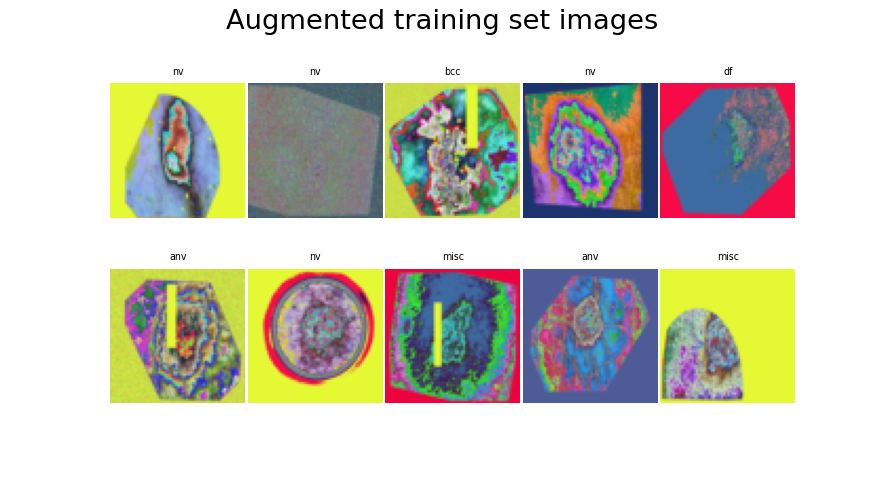

Sampling validation samples...


<IPython.core.display.Javascript object>


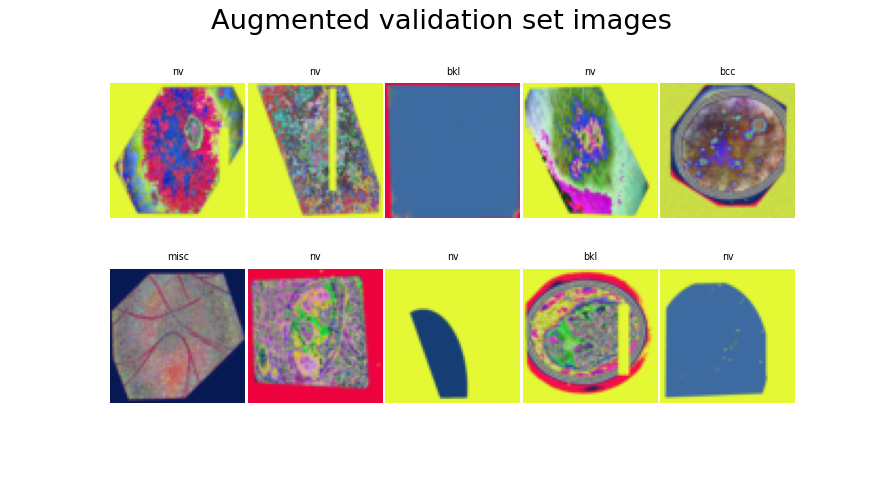

In [28]:
if settings['visualize_transforms']: 
    def denormalise(image):
        image = image.numpy().transpose(1, 2, 0)  # PIL images have channel last
        #mean = [0.485, 0.456, 0.406]
        #stdd = [0.229, 0.224, 0.225]
        #image = (image * stdd + mean).clip(0, 1)
        return image


    example_rows = 2
    example_cols = 5
    num_samples = example_rows * example_cols
    print("Sampling training samples...")
    _sampler = torch.utils.data.RandomSampler(data_set, num_samples=num_samples, 
                                                     replacement=True)

    # Get a batch of images and labels  
    indices  = np.array([next(iter(_sampler)) for i in range(num_samples)])
    images = [data_set[_idx][0] for _idx in indices]

    plt.rcParams['figure.dpi'] = 90  # Increase size of pyplot plots

    # Show a grid of example images    
    fig, axes = plt.subplots(example_rows, example_cols, figsize=(9, 5)) #  sharex=True, sharey=True)
    axes = axes.flatten()
    for ax, image, index in zip(axes, images, indices):
        ax.imshow(denormalise(image))
        ax.set_axis_off()
        ax.set_title(inds_class[target_vector[index]], fontsize=7)

    fig.subplots_adjust(wspace=0.02, hspace=0)
    fig.suptitle('Augmented training set images', fontsize=20)
    plt.show()
    
    ##################################
    print("Sampling validation samples...")
    _sampler2 = torch.utils.data.RandomSampler(data_set_val, num_samples=num_samples, 
                                                     replacement=True)

    # Get a batch of images and labels  
    indices  = np.array([next(iter(_sampler2)) for i in range(num_samples)])
    images = [data_set[_idx][0] for _idx in indices]

    plt.rcParams['figure.dpi'] = 90  # Increase size of pyplot plots

    # Show a grid of example images    
    fig, axes = plt.subplots(example_rows, example_cols, figsize=(9, 5)) #  sharex=True, sharey=True)
    axes = axes.flatten()
    for ax, image, index in zip(axes, images, indices):
        ax.imshow(denormalise(image))
        ax.set_axis_off()
        ax.set_title(inds_class[target_vector[index]], fontsize=7)

    fig.subplots_adjust(wspace=0.02, hspace=0)
    fig.suptitle('Augmented validation set images', fontsize=20)
    plt.show()
    

In [18]:
from contextlib import contextmanager

@contextmanager
def set_default_tensor_type(device):
    if 'cuda' in str(device):
        tensor_type = torch.cuda.FloatTensor
    else:
        tensor_type = torch.FloatTensor
        
    if torch.tensor(0).is_cuda:
        old_tensor_type = torch.cuda.FloatTensor
    else:
        old_tensor_type = torch.FloatTensor
        
    torch.set_default_tensor_type(tensor_type)
    yield
    torch.set_default_tensor_type(old_tensor_type)

In [19]:
# we have to indicate what part of the network we actually want to update based on the new training set
#if (settings['num_gpu']<2) | (settings['use_cpu']==True):
children_iter = model.children()
param_iter = model.parameters()
tot_num_layers = max([idx for idx,_ in enumerate(model.children())])
#else:
#    children_iter = model.module.children()
#    param_iter = model.module.parameters()
#    tot_num_layers = max([idx for idx,_ in enumerate(model.module.children())])

ct = 0
trainable_c = 0
if settings['num_layers_trainable']>-1:
    for child in children_iter:
        ct += 1
        if ct>(tot_num_layers-settings['num_layers_trainable']):
            for param in child.parameters():
                param.requires_grad = True
                trainable_c += 1
        else:
            for param in child.parameters():
                param.requires_grad = False            
    params = [p for p in param_iter if p.requires_grad]
    model_depth = ct
else:
    ct = tot_num_layers
    params = param_iter
    
#print("The last {} from a total of {} layers are trainable".format(trainable_c, ct))

In [20]:
trainable_parameters = 0
for parameter in model.parameters():
    trainable_parameters += 1 if parameter.requires_grad else 0
print("{} parameter layers are trainable".format(trainable_parameters))

213 parameter layers are trainable


## optimizer

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DOES NOT WORK YET
'''
class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )
'''
class MulticlassFocalLoss(nn.Module):
    
    def __init__(self, train_targets=None, gamma=2):
        super(MulticlassFocalLoss, self).__init__()
        self.gamma = gamma
        if train_targets is None:
            self.class_weights = None
        else:
            weights = compute_class_weight(y=train_targets,
                                   class_weight="balanced",
                                   classes=np.unique(train_targets))    
            self.class_weights = torch.FloatTensor(weights)
            if device.type=="cuda":
                self.class_weights = self.class_weights.cuda()
    
    def forward(self, input, target):
        if self.class_weights is None:
            ce_loss = F.cross_entropy(input, target, reduction='none')
        else:
            ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.class_weights)
        pt = torch.exp(-ce_loss)
        loss = (1-pt)**self.gamma * ce_loss
        return torch.mean(loss)

In [22]:
if settings['criterion'] == 'BCE':
    assert num_classes==2, 'BCE loss requires a single output, perhaps use CrossEntropy or Focal loss?'
    num_classes = 1

try:
    if 'cuda' in str(device):
        '''
        if settings['num_gpu']>1:
            for _param in model.module.named_parameters():
                pass
            classifier_head = ".".join(_param[0].split(".")[:-1])
            old_in = eval("model.module."+classifier_head+".in_features")
            try:
                exec_str = "model.module."+classifier_head+"= nn.Linear(in_features="+str(old_in)+", out_features="+str(num_classes)+").to(device)"
            except Exception as e:
                print("Could not create execution string: {}".format(e))
            exec(exec_str)
            exec("model.module."+classifier_head+".volatile=False")
            exec("model.module."+classifier_head+".requires_grad_=True")
        else:
        '''
        for _param in model.named_parameters():
            pass
        classifier_head = ".".join(_param[0].split(".")[:-1])
        old_in = eval("model."+classifier_head+".in_features")
        exec("model."+classifier_head+"= nn.Linear(in_features="+str(old_in)+", out_features="+str(num_classes)+").to(device)")
        exec("model."+classifier_head+".volatile=False")
        exec("model."+classifier_head+".requires_grad_=True")
    else:
        for _param in model.named_parameters():
            pass
        classifier_head = ".".join(_param[0].split(".")[:-1])
        old_in = eval("model."+classifier_head+".in_features")
        exec("model."+classifier_head+"= nn.Linear(in_features=old_in, out_features=num_classes).to(device)")
except Exception as e:
    print("Could not reset linear layer".format(e))


In [23]:
# optimizer
learning_rate = settings['learning_rate']
if settings['optimiser'] == 'Adam':
    optimizer = torch.optim.Adam(params, lr=learning_rate)
elif settings['optimiser'] == 'RMSProp':
    optimizer = torch.optim.RMSprop(params, lr=learning_rate)
elif settings['optimiser'] == 'ASGD':
    optimizer = torch.optim.ASGD(params, lr=learning_rate)
elif settings['optimiser'] == 'AdaTuneAdam':
    from adatune import hd_adam
    optimizer = hd_adam.AdamHD(params, lr=learning_rate)    
elif settings['optimiser'] == 'AdaTuneSGD':
    from adatune import hd_sgd
    optimizer = hd_sgd.SGDHD(params, lr=learning_rate)     

if settings['train_schedule'] =='StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=settings['lrStep'], gamma=0.8)
elif settings['train_schedule'] =='CyclicLR':
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                               base_lr=learning_rate,
                                               max_lr=0.001,
                                               step_size_up=int(settings['lrStep']/2),
                                               step_size_down=int(settings['lrStep']/2),
                                               cycle_momentum=False,
                                               gamma=0.7,
                                               mode="exp_range")
elif settings['train_schedule'] == 'CosAnnealing':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
else:
    scheduler = None


if str(device)=='cpu':
    print('cpu-criterion')
    if settings['weighted_loss']:
        _weights = torch.FloatTensor(class_weights.astype(np.float32))
    else:
        _weights = None
    if settings['criterion'] == 'cross_entropy':
        criterion = nn.CrossEntropyLoss(weight=_weights,
                                        reduction='mean')
    elif settings['criterion'] == 'focal':
        criterion = MulticlassFocalLoss(train_targets=target_vector)
    elif settings['criterion'] == 'BCE':
        assert num_classes<3, 'BCE loss requires a single output, perhaps use CrossEntropy or Focal loss'
        model.classifier = nn.Linear(model.classifier.in_features, 2).to(device)
        criterion = nn.BCEWithLogitsLoss(reduce=False)
else:
    print('gpu-criterion')
    if settings['weighted_loss']:
        _weights = torch.cuda.FloatTensor(class_weights.astype(np.float32))
    else:
        _weights = None
        
    if settings['criterion'] == 'cross_entropy':
        criterion = nn.CrossEntropyLoss(weight=_weights, reduction='mean')
    elif settings['criterion'] == 'focal':
        criterion = MulticlassFocalLoss(train_targets=target_vector)
    elif settings['criterion'] == 'BCE':
        print("BCE loss")       
        criterion = nn.BCEWithLogitsLoss(reduce=False) 

gpu-criterion


In [24]:
def _get_auc(yt,yp, weights=None):
    if(weights is None):
        weights=np.ones((np.max(yt)+1,))
        
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros((np.unique(yt).shape[0],))
    wtot = 0 
    for c,i in enumerate(np.unique(yt)):
        fpr[i], tpr[i], _ = roc_curve(yt==i, yp[:, i])
        roc_auc[c] = weights[i]*auc(fpr[i], tpr[i])
        wtot = wtot+weights[i]
    return np.sum(roc_auc)/wtot

def get_auc_score(y_pred, y_train, weights=None, dim=1, detach=True):
    sm = nn.Softmax(dim=dim)

    if detach:
        yt = y_train.detach().to(device).cpu().numpy()
        yp = sm(y_pred).detach().to(device).cpu().numpy()  
    else:
        yt = y_train
        yp = y_pred
    
    # torch.sigmoid(y_pred).detach().to(device).cpu().numpy() 
    try:
        return roc_auc_score(yt, yp, multi_class='ovr', average='weighted')
    except Exception as e:
        try:
            return _get_auc(yt, yp, weights=weights)            
        except:
            print('AUC problemos:', e, yp.shape, yt.shape)
            
            
def get_average_recall(y_pred, y_train, dim=1, detach=True):
    sm = nn.Softmax(dim=dim)

    if detach:
        yt = y_train.detach().to(device).cpu().numpy()
        yp = sm(y_pred).detach().to(device).cpu().numpy()  
    else:
        yt = y_train
        yp = y_pred
        
    yp = np.argmax(yp, axis=1) if dim==1 else np.round(yp).astype(int)
    return recall_score(yt, yp, average='macro', zero_division=0)

In [25]:
if settings['use_amp']:
    from apex import amp
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    
if settings['num_gpu']>1:
    print("Multiple GPU's")
    model= nn.DataParallel(model)
    model.to(device)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [26]:
def get_validation_scores(model_to_validate, val_loader):
    model_to_validate.eval()
    val_iter = iter(val_loader)
    
    aucs = []
    recalls = []
    
    preds_list = []
    labels_list = []
    with torch.no_grad():
        for i in tqdm(range(len(val_loader))):
            data_batched = val_iter.next()
            data = [_.cuda(non_blocking=True) for _ in data_batched] if \
                                on_gpu else [_ for _ in data_batched]
            inputs, labels = data
            if 'cuda' in str(device):               
                inputs = inputs.to('cuda', non_blocking=True)
                labels = labels.to('cpu')
            else:
                inputs = inputs.to(device)
                labels = labels.to('cpu').numpy()
            
            # TODO first stack in torch tensors, then send to cpu?
            preds = model_to_validate(inputs).to('cpu').numpy()
            #preds = np.reshape(preds)
            labels = np.reshape(labels, (-1,1))
            
            preds_list.append(preds)
            labels_list.append(labels)
            
        preds_list = tuple(preds_list)
        labels_list = tuple(labels_list)
        
        spreds = np.vstack(preds_list)
        slabels = np.vstack(labels_list)
        
        
        
        _auc = get_auc_score(spreds, slabels,
                             weights=class_weights, dim=1, 
                             detach=False)
        _rec = get_average_recall(spreds, slabels, dim=1,
                                 detach=False)

    return _auc, _rec

<IPython.core.display.Javascript object>


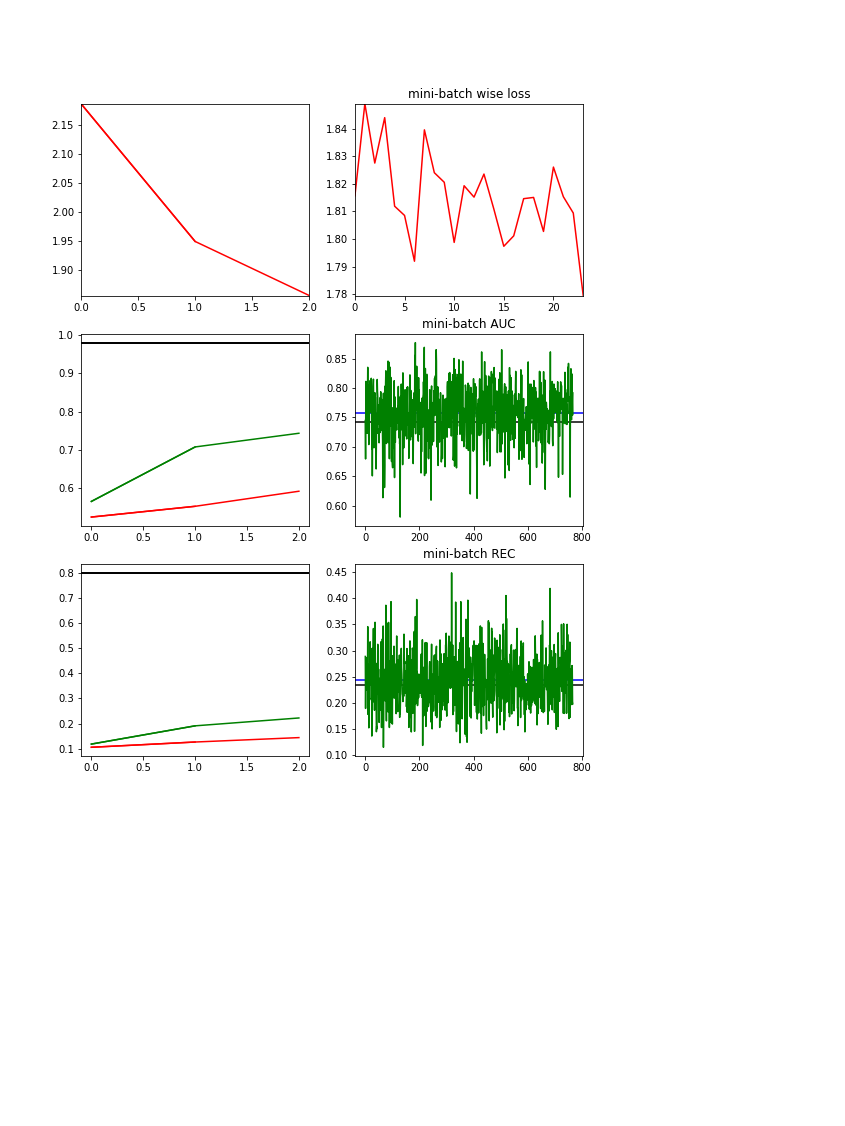

++++++++++++++++++++++++++++++ Starting run, total 20 epochs, on 50911 samples per fold, with a mini-batch size of 64
Training with CUDA
STARTING ON FOLD: 0
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[1,    32] loss: 2.331


<ipython-input-27-5c8ffbfc8b32>:148: UserWarning: Attempting to set identical bottom == top == 2.33084187656641 results in singular transformations; automatically expanding.
  ax[0,1].set_ylim(np.nanmin(sloss_list), np.nanmax(sloss_list))
<ipython-input-27-5c8ffbfc8b32>:149: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax[0,1].set_xlim(0, pc)


[1,    64] loss: 2.322
[1,    96] loss: 2.293
[1,   128] loss: 2.260
[1,   160] loss: 2.244
[1,   192] loss: 2.233
[1,   224] loss: 2.232
[1,   256] loss: 2.202
[1,   288] loss: 2.221
[1,   320] loss: 2.214
[1,   352] loss: 2.196
[1,   384] loss: 2.172
[1,   416] loss: 2.183
[1,   448] loss: 2.176
[1,   480] loss: 2.165
[1,   512] loss: 2.150
[1,   544] loss: 2.137
[1,   576] loss: 2.124
[1,   608] loss: 2.132
[1,   640] loss: 2.120
[1,   672] loss: 2.118
[1,   704] loss: 2.117
[1,   736] loss: 2.120
[1,   768] loss: 2.117


100%|██████████| 198/198 [15:14<00:00,  4.62s/it] 
/media/bramiozo/home/bramiozo/VIRTUALENVS/torch_image/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:111: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
<ipython-input-27-5c8ffbfc8b32>:201: UserWarning: Attempting to set identical bottom == top == 2.1875968366786274 results in singular transformations; automatically expanding.
  ax[0,0].set_ylim(np.nanmin(loss_list), np.nanmax(loss_list))
<ipython-input-27-5c8ffbfc8b32>:202: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax[0,0].set_xlim(0, e)



2.1875968366786274
++++++++++++++++++++++++++++++++++++++++++++++++++
AdamHD (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    hypergrad_lr: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
++++++++++++++++++++++++++++++++++++++++++++++++++
[2,    32] loss: 2.135


<ipython-input-27-5c8ffbfc8b32>:149: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax[0,1].set_xlim(0, pc)


[2,    64] loss: 2.044
[2,    96] loss: 2.034
[2,   128] loss: 1.993
[2,   160] loss: 2.010
[2,   192] loss: 2.011
[2,   224] loss: 1.972
[2,   256] loss: 1.966
[2,   288] loss: 1.939
[2,   320] loss: 1.954
[2,   352] loss: 1.947
[2,   384] loss: 1.925
[2,   416] loss: 1.946
[2,   448] loss: 1.922
[2,   480] loss: 1.912
[2,   512] loss: 1.948
[2,   544] loss: 1.893
[2,   576] loss: 1.923
[2,   608] loss: 1.897
[2,   640] loss: 1.906
[2,   672] loss: 1.899
[2,   704] loss: 1.859
[2,   736] loss: 1.854
[2,   768] loss: 1.918


100%|██████████| 198/198 [14:49<00:00,  4.49s/it]



1.9487069669538541
++++++++++++++++++++++++++++++++++++++++++++++++++
AdamHD (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    hypergrad_lr: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
++++++++++++++++++++++++++++++++++++++++++++++++++
[3,    32] loss: 1.912


<ipython-input-27-5c8ffbfc8b32>:149: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax[0,1].set_xlim(0, pc)


[3,    64] loss: 1.859
[3,    96] loss: 1.860
[3,   128] loss: 1.856
[3,   160] loss: 1.878
[3,   192] loss: 1.880
[3,   224] loss: 1.871
[3,   256] loss: 1.863
[3,   288] loss: 1.847
[3,   320] loss: 1.881
[3,   352] loss: 1.832
[3,   384] loss: 1.852
[3,   416] loss: 1.855
[3,   448] loss: 1.861
[3,   480] loss: 1.867
[3,   512] loss: 1.828
[3,   544] loss: 1.827
[3,   576] loss: 1.848
[3,   608] loss: 1.860
[3,   640] loss: 1.829
[3,   672] loss: 1.835
[3,   704] loss: 1.827
[3,   736] loss: 1.850
[3,   768] loss: 1.829


100%|██████████| 198/198 [14:49<00:00,  4.49s/it] 



1.854939617948508
++++++++++++++++++++++++++++++++++++++++++++++++++
AdamHD (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    hypergrad_lr: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
++++++++++++++++++++++++++++++++++++++++++++++++++
[4,    32] loss: 1.816


<ipython-input-27-5c8ffbfc8b32>:149: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax[0,1].set_xlim(0, pc)


[4,    64] loss: 1.849
[4,    96] loss: 1.828
[4,   128] loss: 1.844
[4,   160] loss: 1.812
[4,   192] loss: 1.809
[4,   224] loss: 1.792
[4,   256] loss: 1.840
[4,   288] loss: 1.824
[4,   320] loss: 1.821
[4,   352] loss: 1.799
[4,   384] loss: 1.819
[4,   416] loss: 1.815
[4,   448] loss: 1.824
[4,   480] loss: 1.811
[4,   512] loss: 1.797
[4,   544] loss: 1.801
[4,   576] loss: 1.815
[4,   608] loss: 1.815
[4,   640] loss: 1.803
[4,   672] loss: 1.826
[4,   704] loss: 1.815
[4,   736] loss: 1.809
[4,   768] loss: 1.779


 36%|███▋      | 72/198 [07:00<13:08,  6.26s/it]  

In [ ]:
fig, ax = plt.subplots(figsize=(9,12), ncols=2, nrows=3)
ax[0,0].set_title('epoch wise loss')
ax[0,1].set_title('mini-batch wise loss')
ax[1,0].set_title('epoch wise AUC')
ax[1,1].set_title('mini-batch AUC')
ax[2,0].set_title('epoch wise average recall')
ax[2,1].set_title('mini-batch average recall')

plt.show(block=False) 
#plt.rcParams['figure.dpi'] = 30 

loss_list = np.zeros((settings['num_epochs'],))
loss_list[:] = np.nan
loss_line, = ax[0,0].plot(loss_list, color='red')

if settings['balancing'] == 'optimizer':
    num_samples = len(data_set.samples)
else:
    num_samples = len(data_set.samples)
    
num_batches = int(num_samples / settings['batch_size'])

plt_batch = 32
sloss_list = np.zeros((int(num_batches/plt_batch),))
sloss_list[:] = np.nan
sloss_line, = ax[0,1].plot(sloss_list, color='red')

plt.pause(0.5)
fig.canvas.draw()

print("+"*30+" Starting run, total {} epochs, on {} samples per fold, with a mini-batch size of {}".format(
settings['num_epochs'], int(num_samples*(settings['cross_folds']-1)/settings['cross_folds']),
    settings['batch_size']))

auc_list = []
rec_list = []

auc_list_val = []
rec_list_val = []

mean_aucs = 0
mean_recs = 0 
if 'cuda' in str(device):
    print("Training with CUDA")
    torch.backends.cudnn.benchmark=True
    torch.backends.cudnn.fastest=True
    torch.backends.cudnn.deterministic=False
    on_gpu = True
else:
    on_gpu = False

# TODO: options to extract inits from list of init pyth.
model_start_weights = torch.save(model.state_dict(), "../_models/melanoma/folds/init.pyth")
for fold in range(settings['cross_folds']):
    if fold>0:
        model.load_state_dict(torch.load("../_models/melanoma/folds/init.pyth"))
    
    print("STARTING ON FOLD: {}".format(fold))
    print("&"*50)
    
    data_loader = data_loaders_train[fold]
    val_loader = data_loaders_val[fold]
    
    try:
        ax[0,0].clear()
        ax[1,0].clear()
        ax[2,0].clear()
        ax[0,1].clear()
        ax[1,1].clear()
        ax[2,1].clear()    
    except:
        print("Tried to clear the plots, ne pasaaaa")
    
    for e, epoch in enumerate(range(settings['num_epochs'])):  # loop over the dataset multiple times
        gc.collect()
        running_loss = 0.0
        srunning_loss = 0.0 
        pc = 0   

        auc_slist = []
        rec_slist = []

        data_iter = iter(data_loader)
        next_batch = data_iter.next()
        next_batch = [_.cuda(non_blocking=True) for _ in next_batch] if \
                        on_gpu else [_ for _ in next_batch]
        #for i, data in enumerate(data_loader, 0):
        for i in range(len(data_loader)):
            if settings['max_batches'] is not None:
                if i>settings['max_batches']:
                    break
            
            # get the inputs; data is a list of [inputs, labels]
            data = next_batch 
            if (i+2)!=len(data_loader):
                next_batch = data_iter.next()
                next_batch = [_.cuda(non_blocking=True) for _ in next_batch] if \
                                on_gpu else [_ for _ in next_batch]

                with set_default_tensor_type(device):
                    inputs, labels = data
                    if 'cuda' in str(device):               
                        inputs = inputs.to('cuda', non_blocking=True)
                        labels = labels.to('cuda', non_blocking=True)
                    else:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs = model(inputs)
                    if settings['criterion']=='BCE':
                        _outputs = outputs[:,0].squeeze()
                        _labels = labels.type_as(outputs[0, 0])
                        loss = criterion(_outputs, _labels)                    
                    #    #loss= torch.cuda.FloatTensor(class_weights.astype(np.float32))                                
                        loss= loss.mean()
                    else:
                        loss = criterion(outputs, labels)
                    y_pred = outputs
                    y_train = labels

                    if settings['criterion']=='BCE':
                        y_pred = _outputs
                        _dim = 0
                    else:
                        _dim = 1

                    auc_slist.append(get_auc_score(y_pred, y_train, weights=class_weights, dim=_dim))
                    rec_slist.append(get_average_recall(y_pred, y_train, dim=_dim))

                    loss.backward()
                    optimizer.step()                

                    # print statistics
                    running_loss += loss.detach().item()
                    srunning_loss += loss.detach().item()        
                    #sloss_list[i]= running_loss

                    if i % plt_batch == (plt_batch-1):    # print every 6 mini-batches            
                        print('[%d, %5d] loss: %.3f' %
                              (epoch + 1, i + 1, srunning_loss/plt_batch))  
                        sloss_list[pc]=srunning_loss/plt_batch

                        ax[0,1].clear()
                        ax[0,1].plot(sloss_list[:pc+1], color='red')
                        ax[0,1].set_ylim(np.nanmin(sloss_list), np.nanmax(sloss_list))
                        ax[0,1].set_xlim(0, pc)            

                        ax[1,1].clear()  
                        ax[1,1].axhline(np.mean(auc_slist), color='blue')
                        ax[1,1].axhline(mean_aucs, color='black')
                        ax[1,1].plot(auc_slist, color='green')      

                        ax[2,1].clear()  
                        ax[2,1].axhline(np.mean(rec_slist), color='blue')
                        ax[2,1].axhline(mean_recs, color='black')
                        ax[2,1].plot(rec_slist, color='green')   

                        ax[0,1].set_title('mini-batch wise loss')
                        ax[1,1].set_title('mini-batch AUC')
                        ax[2,1].set_title('mini-batch REC')

                        srunning_loss = 0.0

                        plt.pause(0.5)
                        fig.canvas.draw()
                        pc = pc + 1
                    if i>0:
                        y_pred_tot = torch.cat([y_pred, y_pred_tot])
                        y_train_tot = torch.cat([y_train, y_train_tot])
                    else:
                        y_pred_tot = y_pred                  
                        y_train_tot = y_train
      
        # TODO get validation scores!
        ####        
        model_copy = model # copy.deepcopy(model)
        val_scores = get_validation_scores(model_copy, val_loader)  
    
        # store checkpoints
        ####
        fold_file_name = "../_models/melanoma/folds/cross_fold_"+str(fold)+"epoch_"+str(e)+"_AUC_"+str(val_scores[0])+".pyth"
        torch.save(model, fold_file_name)
        
        if scheduler is not None:
            scheduler.step()
            print()

        mean_aucs = np.mean(auc_slist)
        mean_recs = np.mean(rec_slist)
        loss_list[e]=running_loss/i
        auc_list.append(get_auc_score(y_pred_tot, y_train_tot))
        rec_list.append(get_average_recall(y_pred_tot, y_train_tot))
        
        auc_list_val.append(val_scores[0])
        rec_list_val.append(val_scores[1])
        
        ax[0,0].plot(loss_list[:e+1], color='red')
        ax[0,0].set_ylim(np.nanmin(loss_list), np.nanmax(loss_list))
        ax[0,0].set_xlim(0, e)

        ax[1,0].plot(auc_list, color='green', label='train')
        ax[1,0].plot(auc_list_val, color='red', label='val')
        ax[1,0].axhline(0.98, color='black')        

        ax[2,0].plot(rec_list, color='green', label='train')
        ax[2,0].plot(rec_list_val, color='red', label='val')
        ax[2,0].axhline(0.8, color='black')
        
        plt.pause(0.5)
        fig.canvas.draw()
        print(running_loss/i)
        print("+"*50)
        print(optimizer)
        print("+"*50)
    print('Finished Training for fold {}:'.format(fold))
    best_val_auc = np.argmax(auc_list_val)
    best_val_rec = np.argmax(rec_list_val)
    ax[1,0].axvline(best_val_auc, color='yellow')
    ax[2,0].axvline(best_val_rec, color='yellow')
    
    ax[1,0].legend()
    ax[2,0].legend()

#plt.ioff()
plt.show()

In [ ]:
data_str = settings['data_folder'].split("/")[-1]
layers_str = str(settings['num_layers_trainable']) if settings['num_layers_trainable']>-1 else 'ALL'
gpu_str = str(settings['num_gpu']) if settings['use_cpu']==False else "0"
trans_string = 'wAugmentation' if settings['image_transforms'] else ''
model_string= settings['base_model']+"_Depth"+layers_str
res_str = str(settings['resolution'][0])+"x"+str(settings['resolution'][1])
opts = "_centercropped" if settings['centercrop'] is not None \
                                else "_randomcropped" if settings['randomcrop'] is not None \
                                    else "_resized"
weighted_loss = '_weightedLoss' if settings['weighted_loss'] else ""
numclasses = "_numClass"+str(num_classes)
amp_str = "_withAMP" if settings['use_amp'] else ""

file_str = '../_models/melanoma/'+model_string+'_'+str(settings['num_epochs'])\
           +'epochs_last'\
           +layers_str+'layers'\
           +opts+'_balancingW'+settings['balancing']\
           +'_batchsize'+str(settings['batch_size'])\
           +'_optimizer'+settings['optimiser']\
           +'_'+settings['train_schedule']\
           +'_numclass'+numclasses\
           +weighted_loss\
           +'_'+trans_string\
           +'_res'+res_str\
           +'_dat'+data_str\
           +'_numGPU'+gpu_str\
           +'_'+settings['criterion']\
           + amp_str\
           +'.pyth'

if (settings['num_gpu']>1) and (settings['use_cpu']==False):    
    torch.save(model.module.state_dict(), file_str)
else:
    if settings['use_amp']:
        checkpoint = {
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'amp': amp.state_dict()
                     }
        torch.save(checkpoint, file_str)
    else:
        torch.save(model, file_str)
print("Saved file to: {}".format(file_str))

In [ ]:
#! gsutil rsync /home/bramiozo/DATA/ISIC2020/_models/melanoma gs://bramiozo/isic2020/models/melanoma
#!ipython.jupyter.save_notebook()

In [ ]:
#!poweroff